# Predicting Glioblastoma Survival Outcomes from Radiomic Features
Udacity Machine Learning Engineer Nanodegree <br>
Kareem Wahid <br>
Last updated: June 13, 2017 <br>

# Import all dependencies

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold

import functools

import seaborn as sns; sns.set(color_codes=True)
sns.set_style("whitegrid")
%matplotlib inline
import matplotlib.pyplot as plt

# Raw Dataset

In [2]:
radiomic_raw = pd.read_csv('radiomics_output_WITHSURVIVAL_raw.csv')
radiomic_raw.head()

,Brats17ID,Image,Mask,Age,Survival,general_info_BoundingBox,general_info_GeneralSettings,general_info_ImageHash,general_info_ImageSpacing,general_info_InputImages,...,original_glszm_LargeAreaEmphasis,original_glszm_ZoneVariance,original_glszm_ZonePercentage,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_SmallAreaEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_ZoneEntropy,original_glszm_SmallAreaLowGrayLevelEmphasis
0,Brats17_2013_11_1,Brats17_2013_11_1_flair.nii,Brats17_2013_11_1_seg.nii,29.120,150,"(115, 88, 45, 58, 60, 60)","{'distances': [1], 'additionalInfo': True, 'en...",286516874ed6844f101e6d495353bde3b486861c,"(1.0, 1.0, 1.0)",{'Original': {}},...,791718.179138,780913.967308,0.009621,14936.565425,4.857379e+07,55.000000,0.498430,0.034596,5.630367,0.017143
1,Brats17_2013_27_1,Brats17_2013_27_1_flair.nii,Brats17_2013_27_1_seg.nii,68.020,120,"(138, 87, 34, 42, 49, 38)","{'distances': [1], 'additionalInfo': True, 'en...",c36bad577d6f4cd0280bad746e50f7bcdd2e372e,"(1.0, 1.0, 1.0)",{'Original': {}},...,126628.990698,123653.922466,0.018334,1818.903693,9.088362e+06,73.655814,0.526228,0.050365,5.748432,0.030350
2,Brats17_CBICA_AAB_1,Brats17_CBICA_AAB_1_flair.nii,Brats17_CBICA_AAB_1_seg.nii,60.463,289,"(70, 102, 41, 50, 56, 37)","{'distances': [1], 'additionalInfo': True, 'en...",4daf9033b834149980edf93394857021e411d107,"(1.0, 1.0, 1.0)",{'Original': {}},...,33324.827080,32690.165229,0.039694,763.749453,2.027000e+06,78.017945,0.488117,0.025907,6.093996,0.014043
3,Brats17_CBICA_AAG_1,Brats17_CBICA_AAG_1_flair.nii,Brats17_CBICA_AAG_1_seg.nii,52.263,616,"(67, 86, 37, 28, 32, 34)","{'distances': [1], 'additionalInfo': True, 'en...",743d470b1be0e8ca7c06b83dd76f6c9664ee91df,"(1.0, 1.0, 1.0)",{'Original': {}},...,7202.748728,7115.915907,0.107314,105.475729,5.429043e+05,218.376399,0.634989,0.011227,6.182728,0.007220
4,Brats17_CBICA_AAL_1,Brats17_CBICA_AAL_1_flair.nii,Brats17_CBICA_AAL_1_seg.nii,54.301,464,"(160, 149, 61, 16, 19, 18)","{'distances': [1], 'additionalInfo': True, 'en...",460c029d619f0370f008ef35376105152290857e,"(1.0, 1.0, 1.0)",{'Original': {}},...,2954.224490,2730.447314,0.066849,396.438798,2.555706e+04,11.857143,0.586383,0.197392,4.051376,0.120535


## Survival data distribution

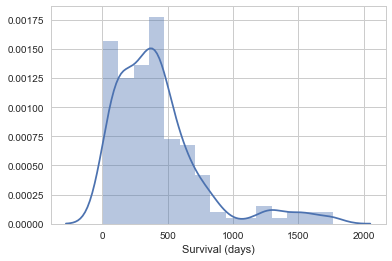

In [3]:
plot = sns.distplot(radiomic_raw['Survival']) # Plot surival data 
plot.set_xlabel('Survival (days)')
fig = plot.get_figure()

#fig.savefig("Survival_distribution.pdf", bbox_inches='tight') # Uncomment to save plot 

# Data Cleaning 

## Remove rows with NaN values and unnecessary columns
Remove all rows with NaN values (geometry mismatch) and the unnecessary columns from the dataset such General Info about the radiomics algorithm. 

In [4]:
radiomic_filtered = radiomic_raw[np.isfinite(radiomic_raw['original_glszm_SmallAreaLowGrayLevelEmphasis'])] # Remove all samples with NaN as value
del radiomic_filtered['Brats17ID'] 
del radiomic_filtered['Image']
del radiomic_filtered['Mask']
del radiomic_filtered['Age']
del radiomic_filtered['general_info_BoundingBox']
del radiomic_filtered['general_info_GeneralSettings']
del radiomic_filtered['general_info_ImageHash']
del radiomic_filtered['general_info_ImageSpacing']
del radiomic_filtered['general_info_InputImages']
del radiomic_filtered['general_info_MaskHash']
del radiomic_filtered['general_info_VoxelNum']
del radiomic_filtered['general_info_Version']
del radiomic_filtered['general_info_VolumeNum']

radiomic_filtered.head()

,Survival,original_shape_Maximum3DDiameter,original_shape_Compactness2,original_shape_Maximum2DDiameterSlice,original_shape_Sphericity,original_shape_MinorAxis,original_shape_Compactness1,original_shape_Elongation,original_shape_SurfaceVolumeRatio,original_shape_Volume,...,original_glszm_LargeAreaEmphasis,original_glszm_ZoneVariance,original_glszm_ZonePercentage,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_SmallAreaEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_ZoneEntropy,original_glszm_SmallAreaLowGrayLevelEmphasis
0,150,72.367120,0.022687,60.827625,0.283090,40.724522,0.007991,0.712809,0.477325,45839.0,...,791718.179138,780913.967308,0.009621,14936.565425,4.857379e+07,55.000000,0.498430,0.034596,5.630367,0.017143
1,120,51.584882,0.032489,44.922155,0.319089,28.339747,0.009562,0.731216,0.667079,11727.0,...,126628.990698,123653.922466,0.018334,1818.903693,9.088362e+06,73.655814,0.526228,0.050365,5.748432,0.030350
2,289,63.000000,0.038263,50.009999,0.336971,36.852581,0.010377,0.731829,0.576298,15443.0,...,33324.827080,32690.165229,0.039694,763.749453,2.027000e+06,78.017945,0.488117,0.025907,6.093996,0.014043
3,616,34.655447,0.397477,30.149627,0.735254,24.172434,0.033447,0.805201,0.314351,9160.0,...,7202.748728,7115.915907,0.107314,105.475729,5.429043e+05,218.376399,0.634989,0.011227,6.182728,0.007220
4,464,21.470911,0.076978,17.464249,0.425392,12.284284,0.014719,0.768372,1.260841,733.0,...,2954.224490,2730.447314,0.066849,396.438798,2.555706e+04,11.857143,0.586383,0.197392,4.051376,0.120535


## Tranform survival data into categorical values
Transform numerical continous survival values to 0 (short term survivor) and 1 (long term survivor).

In [5]:
radiomic_filtered.loc[radiomic_filtered.Survival < 360, 'Survival'] = 0
radiomic_filtered.loc[radiomic_filtered.Survival >= 360, 'Survival'] = 1

radiomic_filtered.head()

/Users/kareemwahid/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Survival,original_shape_Maximum3DDiameter,original_shape_Compactness2,original_shape_Maximum2DDiameterSlice,original_shape_Sphericity,original_shape_MinorAxis,original_shape_Compactness1,original_shape_Elongation,original_shape_SurfaceVolumeRatio,original_shape_Volume,...,original_glszm_LargeAreaEmphasis,original_glszm_ZoneVariance,original_glszm_ZonePercentage,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_SmallAreaEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_ZoneEntropy,original_glszm_SmallAreaLowGrayLevelEmphasis
0,0,72.367120,0.022687,60.827625,0.283090,40.724522,0.007991,0.712809,0.477325,45839.0,...,791718.179138,780913.967308,0.009621,14936.565425,4.857379e+07,55.000000,0.498430,0.034596,5.630367,0.017143
1,0,51.584882,0.032489,44.922155,0.319089,28.339747,0.009562,0.731216,0.667079,11727.0,...,126628.990698,123653.922466,0.018334,1818.903693,9.088362e+06,73.655814,0.526228,0.050365,5.748432,0.030350
2,0,63.000000,0.038263,50.009999,0.336971,36.852581,0.010377,0.731829,0.576298,15443.0,...,33324.827080,32690.165229,0.039694,763.749453,2.027000e+06,78.017945,0.488117,0.025907,6.093996,0.014043
3,1,34.655447,0.397477,30.149627,0.735254,24.172434,0.033447,0.805201,0.314351,9160.0,...,7202.748728,7115.915907,0.107314,105.475729,5.429043e+05,218.376399,0.634989,0.011227,6.182728,0.007220
4,1,21.470911,0.076978,17.464249,0.425392,12.284284,0.014719,0.768372,1.260841,733.0,...,2954.224490,2730.447314,0.066849,396.438798,2.555706e+04,11.857143,0.586383,0.197392,4.051376,0.120535


## Survival classes distribution after data cleaning and stratifying
Survival classes are shown to be approximatley equal after stratification process. 

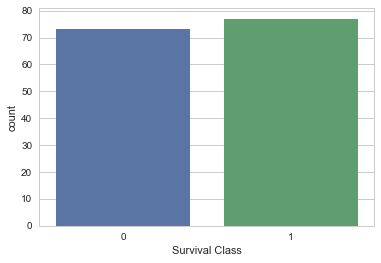

In [6]:
# Make plot
survivalbox = sns.countplot(x="Survival", data = radiomic_filtered)

# Modify plot
survivalbox.set_xlabel('Survival Class')
fig = survivalbox.get_figure()

#fig.savefig("Survival_0_1_distribution.pdf", bbox_inches='tight') # Uncomment to save

# Feature Exploration 

## Feature Statistics Table for select features

In [7]:
radiomic_filtered[['original_firstorder_Variance','original_shape_Volume', 'original_glcm_Autocorrelation', 
               'original_glszm_SmallAreaEmphasis', 'original_glrlm_ShortRunEmphasis']].describe()

,original_firstorder_Variance,original_shape_Volume,original_glcm_Autocorrelation,original_glszm_SmallAreaEmphasis,original_glrlm_ShortRunEmphasis
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,8643.939274,11856.813333,190.708194,0.552885,0.809201
std,14328.384058,14355.168518,215.694998,0.076401,0.100613
min,20.583814,47.000000,5.112822,0.334238,0.313110
25%,2034.993231,3274.750000,67.445700,0.497041,0.746117
50%,4273.065840,7820.500000,118.009713,0.564855,0.838175
75%,8120.411208,15919.750000,240.788684,0.605882,0.875534
max,98968.979609,91299.000000,1329.476095,0.740891,0.960379


## Scatterplot of two shape features

Short term survivors show only sliglty higher tumor volume and diameter when compared to long term survivors. This highlights the need to consider more than just the tumor shape when analyzing a MRI image of Glioblastoma. 

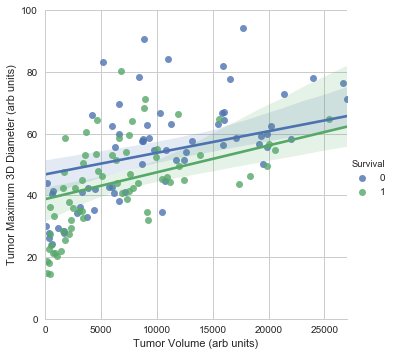

In [8]:
# Make plot
shapescatter = sns.lmplot(x="original_shape_Volume", y="original_shape_Maximum3DDiameter", hue = 'Survival',
                 data = radiomic_filtered, fit_reg=True)

# Modify plot
shapescatter.set(ylim=(0, 100), xlim = (0, 27000))
shapescatter.set_ylabels('Tumor Maximum 3D Diameter (arb units)')
shapescatter.set_xlabels('Tumor Volume (arb units)')

#shapescatter.savefig("Volume_vs_3DDiamter.pdf", bbox_inches='tight') # Uncomment to save 

# Main Implementation 
Any function that can be set to a random state should be set to one to ensure reproduciblity. All print outputs are for debugging purposes. If one wishes to add or remove classifiers they should make the neccessary changes to the clf_list, parameters_list, and scores_list. 

In [10]:
%%time

from sklearn.metrics import accuracy_score

### Classifier intialization, all should be set to random state
clf_A = RandomForestClassifier(random_state=0) 
clf_B = GaussianNB()
clf_C = DecisionTreeClassifier(random_state=0)
clf_D = MLPClassifier(random_state=0)
clf_E = BaggingClassifier(random_state=0)
clf_F = GradientBoostingClassifier(random_state=0)
clf_G = SVC(random_state=0)
clf_H = LogisticRegression(random_state=0)
clf_I = KNeighborsClassifier()
clf_J = QuadraticDiscriminantAnalysis()
clf_list = [clf_A, clf_B, clf_C, clf_D, clf_E, clf_F, clf_G, clf_H, clf_I, clf_J]

### Parameters to use for GridSearch
parameters_A = {'min_samples_split':[2,20,30], 'n_estimators':[500]}
parameters_B = None 
parameters_C = {'min_samples_split':[2,20,30]}
parameters_D = {'hidden_layer_sizes':[(100,),(1,),(9,)],'beta_1':[0.9, 0.1, 0.0001]}
parameters_E = {'n_estimators':[5,10,100]}
parameters_F = {'n_estimators': [1,10,20,100]}
parameters_G = {'C':[0.1,1.0,10.0], 'kernel':['poly', 'rbf']}
parameters_H = {'C':[0.1,1.0,10.0], 'penalty':['l1','l2']}
parameters_I = {'n_neighbors':[5,10,15,20]}
parameters_J = None  

parameters_list = [parameters_A, parameters_B, parameters_C, parameters_D, parameters_E, 
                   parameters_F, parameters_G, parameters_H, parameters_I, parameters_J]

### Lists where scores will be stored for later analysis, Letter represents scoring function 
# A = ANOVA F-score, M = Mutual Information, C = Chi^2, numbers represent top number of features selected 
scores_A = {'A10':[], 'A20':[], 'A30':[], 'A40':[], 'M10':[], 'M20':[], 'M30':[], 'M40':[], 'C10':[], 
                     'C20':[], 'C30':[], 'C40':[]}
scores_B = {'A10':[], 'A20':[], 'A30':[], 'A40':[], 'M10':[], 'M20':[], 'M30':[], 'M40':[], 'C10':[], 
                     'C20':[], 'C30':[], 'C40':[]}
scores_C = {'A10':[], 'A20':[], 'A30':[], 'A40':[], 'M10':[], 'M20':[], 'M30':[], 'M40':[], 'C10':[], 
                     'C20':[], 'C30':[], 'C40':[]}
scores_D = {'A10':[], 'A20':[], 'A30':[], 'A40':[], 'M10':[], 'M20':[], 'M30':[], 'M40':[], 'C10':[], 
                     'C20':[], 'C30':[], 'C40':[]}
scores_E = {'A10':[], 'A20':[], 'A30':[], 'A40':[], 'M10':[], 'M20':[], 'M30':[], 'M40':[], 'C10':[], 
                     'C20':[], 'C30':[], 'C40':[]}
scores_F = {'A10':[], 'A20':[], 'A30':[], 'A40':[], 'M10':[], 'M20':[], 'M30':[], 'M40':[], 'C10':[], 
                     'C20':[], 'C30':[], 'C40':[]}
scores_G = {'A10':[], 'A20':[], 'A30':[], 'A40':[], 'M10':[], 'M20':[], 'M30':[], 'M40':[], 'C10':[], 
                     'C20':[], 'C30':[], 'C40':[]}
scores_H = {'A10':[], 'A20':[], 'A30':[], 'A40':[], 'M10':[], 'M20':[], 'M30':[], 'M40':[], 'C10':[], 
                     'C20':[], 'C30':[], 'C40':[]}
scores_I = {'A10':[], 'A20':[], 'A30':[], 'A40':[], 'M10':[], 'M20':[], 'M30':[], 'M40':[], 'C10':[], 
                     'C20':[], 'C30':[], 'C40':[]}
scores_J = {'A10':[], 'A20':[], 'A30':[], 'A40':[], 'M10':[], 'M20':[], 'M30':[], 'M40':[], 'C10':[], 
                     'C20':[], 'C30':[], 'C40':[]}
scores_list = [scores_A, scores_B, scores_C, scores_D, scores_E, scores_F, scores_G, scores_H, scores_I, scores_J]

list_combined = zip(clf_list, parameters_list, scores_list) # Zip lists together for use below 

mutual_info_classif =  functools.partial(mutual_info_classif, random_state = 0) # Need to redefine to enable random_state

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0) # Cross validation parameters for use in grid search

for i in range(10): # Repeat the following 10 times, can change this to higher values but will slow computational time.
    
    # Split full dataset into train and test set 
    train, test = train_test_split(radiomic_filtered, test_size = 0.2, random_state=i) 
    survival_classes_train = train['Survival']  
    features_train = train.drop('Survival', axis = 1)
    survival_classes_test = test['Survival'] 
    features_test = test.drop('Survival', axis = 1)

    # Normalizing features using z-score with respect to training set
    scaler = MinMaxScaler().fit(features_train)
    features_train_transformed = scaler.transform(features_train)
    features_train_transformed = pd.DataFrame(features_train_transformed)
    features_test_transformed = scaler.transform(features_test)
    features_test_transformed = pd.DataFrame(features_test_transformed)

    # Select top features using different feature numbers and feature selction methods and store in lists  
    feature_number_list = [10,20,30,40]
    score_func_list = [f_classif, mutual_info_classif, chi2]
    features_train_transformed_selected_list =[]
    features_test_transformed_selected_list =[]
    for feature_number in feature_number_list:
        for score_func in score_func_list:
            selector3 = SelectKBest(k = feature_number, score_func = score_func).fit(features_train_transformed, survival_classes_train)
            features_train_transformed_selected = selector3.transform(features_train_transformed) 
            features_train_transformed_selected = pd.DataFrame(features_train_transformed_selected) 
            features_train_transformed_selected_list.append(features_train_transformed_selected)
            features_test_transformed_selected = selector3.transform(features_test_transformed)
            features_test_transformed_selected = pd.DataFrame(features_test_transformed_selected)
            features_test_transformed_selected_list.append(features_test_transformed_selected)
    features_zipped = zip(features_train_transformed_selected_list, features_test_transformed_selected_list)

    ### Training and prediction algorithm 
    for clf, parameters, scores in list_combined:
        counter = 0 # Feature number counter  
        counter2 = 0 # Feature selection method counter, 1 = ANOVA F-score, 2 = Mutial Information, 3 = Chi^2 
        for x1,x2  in features_zipped:
            if parameters == None: # Classifiers without hyperparameters skip tuning step
                best_clf = clf.fit(x1, survival_classes_train)
            else: # Classifier with hyperparameters are tuned with cross validation 
                scorer = make_scorer(roc_auc_score)
                grid_obj = GridSearchCV(clf, parameters, scorer, cv = cv)  
                grid_fit = grid_obj.fit(x1, survival_classes_train)
                best_clf = grid_fit.best_estimator_
            print best_clf # for debugging purposes
            clf_name = best_clf.__class__.__name__
            counter += 10   
            counter2 += 1 
            if counter2 == 1: # ANOVA F-score
                b = roc_auc_score(survival_classes_test, best_clf.predict(x2))
                scores['A' + str(counter)].append(b)
                print str(clf_name) + ' ' + str(counter) + ' ANOVA features:' + " score = " + str(b) # for debugging purposes
                counter -= 10
            elif counter2 == 2: # Mutual Information
                b = roc_auc_score(survival_classes_test, best_clf.predict(x2))
                scores['M' + str(counter)].append(b)
                print str(clf_name) + ' ' + str(counter) + ' MI features:' + " score = " + str(b) # for debugging purposes
                counter -= 10
            elif counter2 == 3: # Chi^2
                b = roc_auc_score(survival_classes_test, best_clf.predict(x2))
                scores['C' + str(counter)].append(b)
                print str(clf_name) + ' ' + str(counter) + ' CHI features:' + " score = " + str(b) # for debugging purposes
                counter2 = 0

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)
RandomForestClassifier 10 ANOVA features: score = 0.525
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=30, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)
RandomForestClassifier 10 MI features: score = 0.45
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')
DecisionTreeClassifier 30 MI features: score = 0.625
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=30, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')
DecisionTreeClassifier 30 CHI features: score = 0.65
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=30, min_weight_fraction_leaf=0.0,
            presort=Fals

/Users/kareemwahid/anaconda/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
MLPClassifier 10 ANOVA features: score = 0.55
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(9,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
MLPClassifier 10 MI features: score = 0.5
MLPClassifier(activation='relu', alpha=0.0001, batch

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
         verbose=0, warm_start=False)
BaggingClassifier 40 ANOVA features: score = 0.55
BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=5, n_jobs=1, oob_score=False, random_state=0,
         verbose=0, warm_start=False)
BaggingClassifier 40 MI features: score = 0.75
BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
         verbose=0, warm_start=False)
BaggingClassifier 40 CHI features: score = 0.575
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=Non

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)
SVC 30 MI features: score = 0.575
SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)
SVC 30 CHI features: score = 0.5
SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)
SVC 40 ANOVA features: score = 0.425
SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)
SVC 40 M

/Users/kareemwahid/anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)
RandomForestClassifier 10 ANOVA features: score = 0.569444444444
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)
RandomForestClassifier 10 MI features: score = 0.638888888889
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_f

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=30, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')
DecisionTreeClassifier 30 CHI features: score = 0.680555555556
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=30, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')
DecisionTreeClassifier 40 ANOVA features: score = 0.680555555556
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
   

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
         verbose=0, warm_start=False)
BaggingClassifier 20 MI features: score = 0.736111111111
BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
         verbose=0, warm_start=False)
BaggingClassifier 20 CHI features: score = 0.736111111111
BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
         verbose=0, warm_start=False)
BaggingClassifier 30 ANOVA features: score = 0.722222222222
BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
 

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)
SVC 10 MI features: score = 0.458333333333
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)
SVC 10 CHI features: score = 0.569444444444
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)
SVC 20 ANOVA features: score = 0.569444444444
SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.0

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')
KNeighborsClassifier 30 CHI features: score = 0.652777777778
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')
KNeighborsClassifier 40 ANOVA features: score = 0.638888888889
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')
KNeighborsClassifier 40 MI features: score = 0.638888888889
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')
KNeighborsClassifier 40 CHI features: score = 0.569444444444
QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariances=Fals

RandomForestClassifier 40 CHI features: score = 0.666666666667
GaussianNB(priors=None)
GaussianNB 10 ANOVA features: score = 0.597222222222
GaussianNB(priors=None)
GaussianNB 10 MI features: score = 0.416666666667
GaussianNB(priors=None)
GaussianNB 10 CHI features: score = 0.5
GaussianNB(priors=None)
GaussianNB 20 ANOVA features: score = 0.555555555556
GaussianNB(priors=None)
GaussianNB 20 MI features: score = 0.458333333333
GaussianNB(priors=None)
GaussianNB 20 CHI features: score = 0.5
GaussianNB(priors=None)
GaussianNB 30 ANOVA features: score = 0.472222222222
GaussianNB(priors=None)
GaussianNB 30 MI features: score = 0.472222222222
GaussianNB(priors=None)
GaussianNB 30 CHI features: score = 0.5
GaussianNB(priors=None)
GaussianNB 40 ANOVA features: score = 0.5
GaussianNB(priors=None)
GaussianNB 40 MI features: score = 0.444444444444
GaussianNB(priors=None)
GaussianNB 40 CHI features: score = 0.5
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(9,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
MLPClassifier 30 ANOVA features: score = 0.597222222222
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(9,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
MLPClassifier 30 MI features: score = 0.597222222222
MLPClassifier(activation='relu', 

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=20, presort='auto', random_state=0,
              subsample=1.0, verbose=0, warm_start=False)
GradientBoostingClassifier 20 MI features: score = 0.666666666667
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=10, presort='auto', random_state=0,
              subsample=1.0, verbose=0, warm_start=False)
GradientBoostingClassifier 20 CHI features: score = 0.638888888889
GradientBoost

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
LogisticRegression 20 CHI features: score = 0.638888888889
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
LogisticRegression 30 ANOVA features: score = 0.597222222222
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
LogisticRegression 30 MI features: score = 0.597222222222
LogisticRegression(C=1.0, class_weig

RandomForestClassifier 10 CHI features: score = 0.696428571429
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)
RandomForestClassifier 20 ANOVA features: score = 0.669642857143
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)
RandomForestClassifier 20 MI features: score = 0.59375
RandomForestClassifier(bootstrap=True, class_weight=Non

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')
DecisionTreeClassifier 40 MI features: score = 0.544642857143
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')
DecisionTreeClassifier 40 CHI features: score = 0.558035714286
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto',
       beta_1=0.0001, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
         verbose=0, warm_start=False)
BaggingClassifier 30 ANOVA features: score = 0.727678571429
BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
         verbose=0, warm_start=False)
BaggingClassifier 30 MI features: score = 0.620535714286
BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
         verbose=0, warm_start=False)
BaggingClassifier 30 CHI features: score = 0.830357142857
BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
 

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)
SVC 20 ANOVA features: score = 0.620535714286
SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)
SVC 20 MI features: score = 0.482142857143
SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)
SVC 20 CHI features: score = 0.620535714286
SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform')
KNeighborsClassifier 40 MI features: score = 0.491071428571
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')
KNeighborsClassifier 40 CHI features: score = 0.59375
QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariances=False, tol=0.0001)
QuadraticDiscriminantAnalysis 10 ANOVA features: score = 0.598214285714
QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariances=False, tol=0.0001)
QuadraticDiscriminantAnalysis 10 MI features: score = 0.566964285714
QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariances=False, tol=0.0001)
QuadraticDiscriminantAnalysis 10 CHI features: score = 0.415178571429
QuadraticDiscri

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=30, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')
DecisionTreeClassifier 10 CHI features: score = 0.513392857143
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=30, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')
DecisionTreeClassifier 20 ANOVA features: score = 0.625
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=30, min_weight_fraction_leaf=0.0,
           

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.1,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(9,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
MLPClassifier 40 MI features: score = 0.433035714286
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto',
       beta_1=0.0001, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
MLPClassifier 40 CHI features: score = 0.455357142857
BaggingClassifier(base_estimat

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=0,
              subsample=1.0, verbose=0, warm_start=False)
GradientBoostingClassifier 30 CHI features: score = 0.540178571429
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=20, presort='auto', random_state=0,
              subsample=1.0, verbose=0, warm_start=False)
GradientBoostingClassifier 40 ANOVA features: score = 0.625
GradientBoostingCl

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
LogisticRegression 40 MI features: score = 0.5
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
LogisticRegression 40 CHI features: score = 0.46875
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform')
KNeighborsClassifier 10 ANOVA features: score = 0.495535714286
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           wei

RandomForestClassifier 30 ANOVA features: score = 0.660714285714
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)
RandomForestClassifier 30 MI features: score = 0.660714285714
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)
RandomForestClassifier 30 CHI features: score = 0.660714285714
RandomForestClassifier(bootstrap=True, class_wei

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
MLPClassifier 10 CHI features: score = 0.691964285714
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.1,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
MLPClassifier 20 ANOVA features: score = 0.5625
MLPClassifier(activation='relu', alp

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=10, presort='auto', random_state=0,
              subsample=1.0, verbose=0, warm_start=False)
GradientBoostingClassifier 10 ANOVA features: score = 0.571428571429
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=10, presort='auto', random_state=0,
              subsample=1.0, verbose=0, warm_start=False)
GradientBoostingClassifier 10 MI features: score = 0.5625
GradientBoostingCla

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)
SVC 40 ANOVA features: score = 0.665178571429
SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)
SVC 40 MI features: score = 0.696428571429
SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)
SVC 40 CHI features: score = 0.696428571429
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='li

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=30, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)
RandomForestClassifier 10 ANOVA features: score = 0.65
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)
RandomForestClassifier 10 MI features: score = 0.55
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_l

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')
DecisionTreeClassifier 30 MI features: score = 0.425
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')
DecisionTreeClassifier 30 CHI features: score = 0.575
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=30, min_weight_fraction_leaf=0.0,
            presort=Fals

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
         verbose=0, warm_start=False)
BaggingClassifier 20 ANOVA features: score = 0.55
BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
         verbose=0, warm_start=False)
BaggingClassifier 20 MI features: score = 0.7
BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=5, n_jobs=1, oob_score=False, random_state=0,
         verbose=0, warm_start=False)
BaggingClassifier 20 CHI features: score = 0.225
BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)
SVC 10 MI features: score = 0.5
SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)
SVC 10 CHI features: score = 0.55
SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)
SVC 20 ANOVA features: score = 0.6
SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)
SVC 20 MI f

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
KNeighborsClassifier 40 ANOVA features: score = 0.375
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')
KNeighborsClassifier 40 MI features: score = 0.5
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
KNeighborsClassifier 40 CHI features: score = 0.35
QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariances=False, tol=0.0001)
QuadraticDiscriminantAnalysis 10 ANOVA features: score = 0.425
QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariances=False, tol=0.0001)
QuadraticDiscriminantAnalysis 10 MI features: score = 0.4
QuadraticDis

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')
DecisionTreeClassifier 10 MI features: score = 0.533333333333
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')
DecisionTreeClassifier 10 CHI features: score = 0.666666666667
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=30, min_weight_fraction_leaf=0.0,
     

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.1,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(9,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
MLPClassifier 40 ANOVA features: score = 0.566666666667
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto',
       beta_1=0.0001, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
MLPClassifier 40 MI features: score = 0.466666666667
MLPClassifier(activation='re

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=10, presort='auto', random_state=0,
              subsample=1.0, verbose=0, warm_start=False)
GradientBoostingClassifier 30 MI features: score = 0.433333333333
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=0,
              subsample=1.0, verbose=0, warm_start=False)
GradientBoostingClassifier 30 CHI features: score = 0.6
GradientBoostingClassif

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
LogisticRegression 40 ANOVA features: score = 0.633333333333
LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
LogisticRegression 40 MI features: score = 0.6
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
LogisticRegression 40 CHI features: score = 0.633333333333
KNeighborsClassifier(algorithm='auto', leaf_si

RandomForestClassifier 20 CHI features: score = 0.566666666667
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)
RandomForestClassifier 30 ANOVA features: score = 0.6
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)
RandomForestClassifier 30 MI features: score = 0.666666666667
RandomForestClassifier(bootstrap=True, class_weight=None, c

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.1,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
MLPClassifier 10 MI features: score = 0.333333333333
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(9,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
MLPClassifier 10 CHI features: score = 0.466666666667
MLPClassifier(activation='relu', 

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
         verbose=0, warm_start=False)
BaggingClassifier 40 CHI features: score = 0.6
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=10, presort='auto', random_state=0,
              subsample=1.0, verbose=0, warm_start=False)
GradientBoostingClassifier 10 ANOVA features: score = 0.466666666667
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)
SVC 40 ANOVA features: score = 0.433333333333
SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)
SVC 40 MI features: score = 0.433333333333
SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)
SVC 40 CHI features: score = 0.433333333333
LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='l

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)
RandomForestClassifier 10 ANOVA features: score = 0.590497737557
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)
RandomForestClassifier 10 MI features: score = 0.70814479638
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_fea

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')
DecisionTreeClassifier 30 CHI features: score = 0.671945701357
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=30, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')
DecisionTreeClassifier 40 ANOVA features: score = 0.622171945701
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=30, min_weight_fraction_leaf=0.0,
  

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
         verbose=0, warm_start=False)
BaggingClassifier 20 ANOVA features: score = 0.658371040724
BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
         verbose=0, warm_start=False)
BaggingClassifier 20 MI features: score = 0.678733031674
BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
         verbose=0, warm_start=False)
BaggingClassifier 20 CHI features: score = 0.610859728507
BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
 

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)
SVC 10 MI features: score = 0.522624434389
SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)
SVC 10 CHI features: score = 0.542986425339
SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)
SVC 20 ANOVA features: score = 0.601809954751
SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')
KNeighborsClassifier 30 CHI features: score = 0.649321266968
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform')
KNeighborsClassifier 40 ANOVA features: score = 0.561085972851
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform')
KNeighborsClassifier 40 MI features: score = 0.678733031674
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
KNeighborsClassifier 40 CHI features: score = 0.561085972851
QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariances=False

# Statistics Table
Basic statistical information (mean, median, std) for the generated list over 10 iterations of AUC values for each classifier/feature selection combination.

In [11]:
feat_combs = ['A10', 'A20', 'A30', 'A40', 'M10', 'M20', 'M30', 'M40', 'C10', 'C20', 'C30', 'C40']
basicstats = []
for feat_comb in feat_combs: 
    d = pd.DataFrame([[str(clf.__class__.__name__), feat_comb[0], feat_comb[1:3], np.mean(scores[feat_comb]), np.median(scores[feat_comb]), 
                       np.std(scores[feat_comb])] for clf, scores in zip(clf_list, scores_list)])
    basicstats.append(d)
basicstats = pd.concat(basicstats, axis=0)
basicstats.columns = ['Classifier', 'Feat_selection', 'Feat_number', 'Mean', 'Med', 'Std']
basicstats.reset_index(inplace=True)
del basicstats['index']

basicstats.head()

,Classifier,Feat_selection,Feat_number,Mean,Med,Std
0,RandomForestClassifier,A,10,0.581887,0.579971,0.075107
1,GaussianNB,A,10,0.560582,0.590278,0.085321
2,DecisionTreeClassifier,A,10,0.591600,0.590278,0.074697
3,MLPClassifier,A,10,0.577931,0.581944,0.057518
4,BaggingClassifier,A,10,0.575798,0.534524,0.102676


# Heatmaps

## Feature Selection Method vs. Classifier

In [12]:
### Feature selection method averaged over feature numbers table
fsm_list = ['A', 'M', 'C']
df = pd.DataFrame(index = fsm_list, columns=[clf.__class__.__name__ for clf in clf_list])
for fsm in fsm_list:
    for clf, scores in zip (clf_list, scores_list):
        df.set_value(str(fsm), str(clf.__class__.__name__), 
                     np.mean(
                         [np.mean(scores[key]) for key in scores if fsm in key]
                     ) # feature selection method averaged over number of features (10,20,30,40)
                    ) 
df.index.name = 'Feature Selection Method'
df = df[df.columns].astype(float)
df.head()

,RandomForestClassifier,GaussianNB,DecisionTreeClassifier,MLPClassifier,BaggingClassifier,GradientBoostingClassifier,SVC,LogisticRegression,KNeighborsClassifier,QuadraticDiscriminantAnalysis
Feature Selection Method,,,,,,,,,,
A,0.601848,0.531607,0.595465,0.560276,0.598439,0.603467,0.568613,0.552138,0.564249,0.517873
M,0.620080,0.453084,0.578143,0.527180,0.621125,0.597004,0.536411,0.545690,0.539952,0.483878
C,0.617452,0.505777,0.588835,0.565378,0.612970,0.645063,0.566777,0.560044,0.565159,0.503280


[<matplotlib.text.Text at 0x118344450>, <matplotlib.text.Text at 0x118572290>]

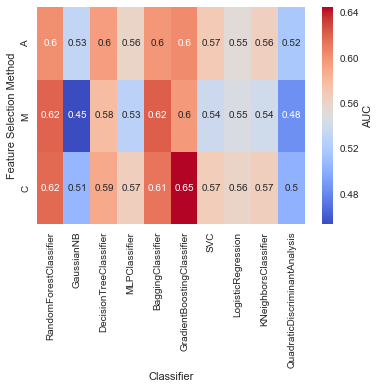

In [13]:
# Heatmap plot 
heatmap1 = sns.heatmap(df, cmap="coolwarm", annot= True, cbar_kws={'label': 'AUC'})
heatmap1.set(xlabel='Classifier', ylabel='Feature Selection Method')

#fig = heatmap1.get_figure()  
#fig.savefig("FSheatmap_6-6-17.pdf", bbox_inches='tight') # Uncomment to save 

## Feature Number vs. Classifier 

In [14]:
### Feature number average over feature selection methods table
fn_list = ['10', '20', '30', '40']
df2 = pd.DataFrame(index = fn_list, columns = [clf.__class__.__name__ for clf in clf_list])
for fn in fn_list:
    for clf, scores in zip (clf_list,scores_list):
        df2.set_value(str(fn), str(clf.__class__.__name__), 
                     np.mean(
                         [np.mean(scores[key]) for key in scores if fn in key]
                     ) # mean across means of each A10 M10 C10 
                    )
df2.index.name = 'Feature Number'
df2 = df2[df2.columns].astype(float)
df2.head()

,RandomForestClassifier,GaussianNB,DecisionTreeClassifier,MLPClassifier,BaggingClassifier,GradientBoostingClassifier,SVC,LogisticRegression,KNeighborsClassifier,QuadraticDiscriminantAnalysis
Feature Number,,,,,,,,,,
10,0.596749,0.505613,0.583132,0.564060,0.595456,0.598943,0.562754,0.564718,0.567019,0.496604
20,0.613996,0.501808,0.590705,0.546061,0.612508,0.621957,0.559639,0.565635,0.561654,0.514089
30,0.616506,0.491876,0.606879,0.543045,0.610218,0.616072,0.549835,0.540827,0.553436,0.494636
40,0.625256,0.487993,0.569208,0.550613,0.625197,0.623739,0.556839,0.539315,0.543704,0.501378


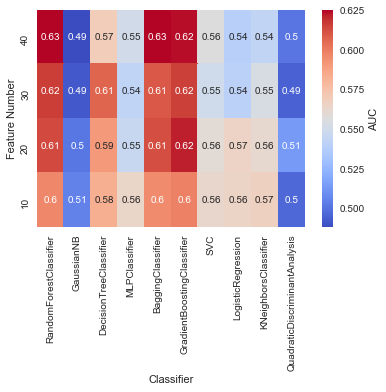

In [15]:
# Heatmap plot
heatmap2 = sns.heatmap(df2, cmap="coolwarm", annot= True, cbar_kws={'label': 'AUC'})
heatmap2.set(xlabel='Classifier', ylabel='Feature Number')
heatmap2.invert_yaxis()

#fig = heatmap2.get_figure() 
#fig.savefig("FNheatmap_6-6-17.pdf", bbox_inches='tight') # Uncomment to save 

# Representative Performance and Stablity 

In [16]:
### Representative RSD and AUC table for each classifier 
df3 = pd.DataFrame(index = [clf.__class__.__name__ for clf in clf_list], columns = ['AUC mean composite', 'AUC std composite', 'RSD'])
for clf, scores in zip(clf_list,scores_list):
    df3.set_value(clf.__class__.__name__, 'AUC mean composite', np.mean([np.mean(scores[key]) for key in scores])) #Averages across all AUC mean values in scores list to get final compostive AUC mean score
    df3.set_value(clf.__class__.__name__, 'AUC std composite', np.mean([np.std(scores[key]) for key in scores])) #Averages across all AUC SD values in scores list to get final compostive SD score
    df3.set_value(clf.__class__.__name__, 'RSD', ((np.mean([np.std(scores[key]) for key in scores])) / (np.mean([np.mean(scores[key]) for key in scores])))*100) # might be able to just add later like so: df['$/hour'] = df['$']/df['hours']

AUC_median = df3["AUC mean composite"].median() # Will use median values in plot in next cell
print "AUC median: " + str(AUC_median)
RSD_median = df3['RSD'].median()
print "RSD median: " + str(RSD_median)

df3.index.name = 'Classifier'
df3.reset_index(inplace=True)

df3

AUC median: 0.556860057324
RSD median: 12.8925037242


,Classifier,AUC mean composite,AUC std composite,RSD
0,RandomForestClassifier,0.613127,0.0713154,11.6314
1,GaussianNB,0.496823,0.0757826,15.2535
2,DecisionTreeClassifier,0.587481,0.0705103,12.0021
3,MLPClassifier,0.550945,0.0692143,12.5629
4,BaggingClassifier,0.610845,0.0889885,14.5681
5,GradientBoostingClassifier,0.615178,0.0689629,11.2102
6,SVC,0.557267,0.0814295,14.6123
7,LogisticRegression,0.552624,0.0643912,11.6519
8,KNeighborsClassifier,0.556453,0.0735751,13.2222
9,QuadraticDiscriminantAnalysis,0.501677,0.0817336,16.2921


## Scatterplot of representative performance and stability

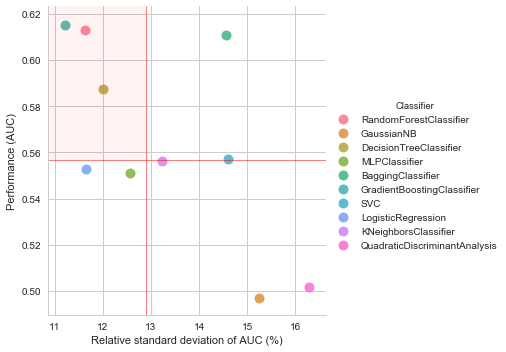

In [17]:
import matplotlib.patches as patches

# Create scatterplot
lm = sns.lmplot(x="RSD", y="AUC mean composite", hue = 'Classifier', data = df3, fit_reg=False, scatter_kws={"s": 100})

# Set labels
lm.set_ylabels('Performance (AUC)')
lm.set_xlabels('Relative standard deviation of AUC (%)')

# Get axis extrema to draw lines and boxes
axes = plt.gca()
y_min, y_max = axes.get_ylim()
x_min, x_max = axes.get_xlim()

# Plot median lines for AUC and RSD + highlighted area for classifiers with AUC > median and RSD < median
plt.axhline(y= AUC_median, linewidth=1, color = 'red', alpha=0.5)
plt.axvline(x= RSD_median, linewidth=1, color = 'red', alpha=0.5)
lm.axes[0][0].add_patch(patches.Rectangle((RSD_median, AUC_median), -x_min, y_max,facecolor="red", alpha = 0.05))

#plt.savefig('Scatterplot_performance_RSD.pdf') # Uncomment to save

# ANOVA
Multivariate Analaysis of Variance (ANOVA) of AUC explained by the experimental factors

In [18]:
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

# Fit linear model 
cw_lm = smf.ols('Mean ~ C(Classifier) + C(Feat_selection) + C(Feat_number) + C(Classifier)*C(Feat_number) + \
                C(Feat_selection)*C(Feat_number) + C(Classifier)*C(Feat_selection)', data=basicstats).fit() #Specify C for Categorical

# Create ANOVA from linear model 
anova = anova_lm(cw_lm, typ=2)
anova.index.name = 'Experimental Factors'
anova.reset_index(inplace=True)
anova['sum_sq'] = anova['sum_sq'].apply(lambda x: (x / anova['sum_sq'].sum())*100) # Tranform sum sq to % variance
anova = anova.rename(columns={'sum_sq': '% Variance'}) # Rename to variance 

anova 

,Experimental Factors,% Variance,df,F,PR(>F)
0,C(Classifier),75.459645,9.0,59.440678,8.062597e-25
1,C(Feat_selection),4.555413,2.0,16.147648,3.184045e-06
2,C(Feat_number),0.326473,3.0,0.771502,5.150107e-01
3,C(Classifier):C(Feat_number),3.909578,27.0,1.026544,4.540735e-01
4,C(Feat_selection):C(Feat_number),0.877544,6.0,1.036882,4.118871e-01
5,C(Classifier):C(Feat_selection),7.254377,18.0,2.857190,1.503115e-03
6,Residual,7.616970,54.0,NaN,NaN


## Barplot for ANOVA

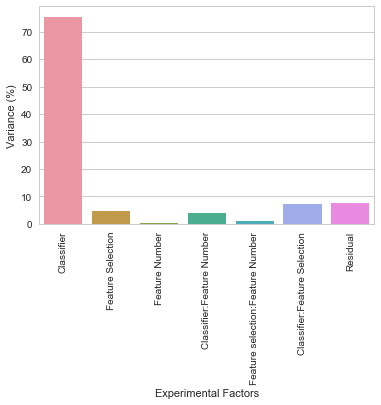

In [19]:
# Creat bar plot for ANOVA factors 
anovaplot = sns.barplot(x="Experimental Factors", y="% Variance", data=anova)

# Change labels 
anovaplot.set_ylabel('Variance (%)')
anovaplot.set_xticklabels(['Classifier', 'Feature Selection', 'Feature Number', 'Classifier:Feature Number', \
                           'Feature selection:Feature Number', 'Classifier:Feature Selection', 'Residual'], rotation=90)

#fig = anovaplot.get_figure()
#fig.savefig("Variation_graph_6-8-17.pdf", bbox_inches='tight') 